In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np

%matplotlib inline

## Fixing Redirects

We load in the raw dataset of wikipedia pages that contain information about the page. 

In [2]:
wikipages = pd.read_csv('../data/raw/enwiki_20190801.page.csv')

In [3]:
wikipages.head()

,page_id,page_title,page_is_redirect,page_len,wikidata_numeric_id,views
0,31880,Universe,0,125156,1.0,37605
1,24437894,Boston,0,188674,100.0,60038
2,12027,Gabon,0,60678,1000.0,24767
3,1313683,Dutch_Wikipedia,0,8325,10000.0,1203
4,4037258,Cadier_en_Keer,0,2584,100000.0,51


In [4]:
wikipages.shape

(14730178, 6)

We noticed that in the raw dataset, 8.7 million pages do not have corresponding wikidata_numeric_ids! This didn't sound right at all. However, we noticed that many pages that are redirect pages do not have a corresponding wikidata_numeric_id. 

In [5]:
wikipages.wikidata_numeric_id.isnull().sum()

8718368

We noticed that many pages that are redirect pages do not have a corresponding wikidata_numeric_id.

In [6]:
wikipages[wikipages.page_is_redirect == 1].tail()

,page_id,page_title,page_is_redirect,page_len,wikidata_numeric_id,views
14730173,24181285,Est.Domain,1,24,NaN,0
14730174,18236087,.p3t,1,51,NaN,0
14730175,7358181,Ceti_Alpha_Six,1,139,NaN,0
14730176,215608,Pascals_Wager,1,85,NaN,0
14730177,49820527,Swimming_at_the_2005_World_Aquatics_Championsh...,1,271,NaN,0


We load in the raw dataset about redirect pages to further investigate. Indeed, we see that while these redirect pages (source pages) do not have a corresponding wikidata_numeric_id, the pages they redirect to (target pages) do. 

In [7]:
redirect = pd.read_csv('../data/raw/enwiki_20190801.redirect.csv')

In [8]:
redirect.head()

,source_page_id,target_page_id,source_page_title,target_page_title
0,39378878,38421275,Infocom_Network,TradeIndia
1,25917412,2238902,Canyonero_(car),The_Last_Temptation_of_Krust
2,3245614,1941596,Chief_Dull_Knife,Morning_Star_(chief)
3,43321056,32960669,National_Register_of_Historic_Places_in_Early_...,National_Register_of_Historic_Places_listings_...
4,13307706,369596,The_New_York_Botanical_Garden,New_York_Botanical_Garden


In [9]:
#Example of source page not having a wikidata_numeric_id but a target page does.
wikipages[wikipages.page_id == redirect[redirect.source_page_id == 24181285]['target_page_id'].iloc[0]]

,page_id,page_title,page_is_redirect,page_len,wikidata_numeric_id,views
3839571,24179837,EstDomains,0,6606,5399970.0,57


We also see examples where a target page not having a wikidata_numeric_id, but one of their source pages does.

In [10]:
wikipages[wikipages.page_id == 325726.0]

,page_id,page_title,page_is_redirect,page_len,wikidata_numeric_id,views
6040736,325726,Social_network_analysis,0,47818,NaN,10825


In [11]:
#All source pages of this target page
redirect[redirect['target_page_id'] == 325726]

,source_page_id,target_page_id,source_page_title,target_page_title
1717720,1559348,325726,Social_Network_Analysis,Social_network_analysis
1721329,12567496,325726,Social_networking_potential,Social_network_analysis
1722555,20645616,325726,Cascade_(Social_Network_Theory),Social_network_analysis
1724358,17661070,325726,Social_Network_Change_Detection,Social_network_analysis
1727934,17576720,325726,Social_network_change_detection,Social_network_analysis
1730560,39596224,325726,Networks_in_Political_Science,Social_network_analysis
1732941,14825621,325726,Social_Networking_Potential,Social_network_analysis


In [12]:
#This source page does not have wikidata_numeric_id
wikipages[wikipages.page_id == 1559348]

,page_id,page_title,page_is_redirect,page_len,wikidata_numeric_id,views
7291787,1559348,Social_Network_Analysis,1,102,NaN,20


In [13]:
#But this source page does
wikipages[wikipages.page_id == 17576720]

,page_id,page_title,page_is_redirect,page_len,wikidata_numeric_id,views
5421981,17576720,Social_network_change_detection,1,37,7551269.0,318


Thus, we need to link these problematic source/target pages with the wikidata_numeric_id of their target/source pages.

In [14]:
#This code cell fixes the problematic behavior mentioned. 

wikipages_cleaned = wikipages.copy()
#Get target page id for all 
target_page_ids = wikipages_cleaned.merge(redirect[['source_page_id', 'target_page_id']],
                          how = 'left', left_on = ['page_id'], right_on = ['source_page_id'])
#Pages that do not appear in redirect have both source_page_id and target_page_id as null after join. These are just page_id for both
target_page_ids['target_page_id'] = target_page_ids['target_page_id'].fillna(target_page_ids['page_id'])
target_page_ids['source_page_id'] = target_page_ids['source_page_id'].fillna(target_page_ids['page_id'])
target_page_ids = target_page_ids.drop(['page_id'], axis = 1)

wikipages_cleaned = target_page_ids.merge(wikipages[['page_id', 'page_title', 'wikidata_numeric_id']], how = 'left', 
                                          left_on = ['target_page_id'], right_on = ['page_id'])

wikipages_cleaned['wikidata_numeric_id_x'] = wikipages_cleaned['wikidata_numeric_id_x'].fillna(
                                                    wikipages_cleaned['wikidata_numeric_id_y'])
wikipages_cleaned = wikipages_cleaned.drop(['wikidata_numeric_id_y', 'page_id'], axis = 1)
wikipages_cleaned = wikipages_cleaned.rename(columns = {'page_title_x': 'page_title', 
                                                        'page_title_y': 'target_page_title',
                                                        'wikidata_numeric_id_x': 'wikidata_numeric_id',
                                                        'source_page_id': 'page_id'
                                                       })
#There are some instances of source page having wikidata instead of target.
#Set target page to have source page wikidata for those
wikidata_ids = wikipages_cleaned.groupby(['target_page_id'])[['wikidata_numeric_id']].min().reset_index()
wikipages_cleaned = wikipages_cleaned.merge(wikidata_ids, how = 'left', on = ['target_page_id'])
wikipages_cleaned['wikidata_numeric_id_x'] = wikipages_cleaned['wikidata_numeric_id_x'].fillna(
                                                    wikipages_cleaned['wikidata_numeric_id_y'])
wikipages_cleaned = wikipages_cleaned.drop(['wikidata_numeric_id_y'], axis = 1)
wikipages_cleaned = wikipages_cleaned.rename(columns = {'wikidata_numeric_id_x': 'wikidata_numeric_id'})



Now only 40k pages have missing wikidata_numeric_id!

In [15]:
wikipages_cleaned.wikidata_numeric_id.isnull().sum()

40693

75% of the articles still without wikidata item have fewer than 10 views. As such, most of these pages are insignificant and should pose no problem to our analysis. 

In [16]:
wikipages_cleaned[wikipages_cleaned.wikidata_numeric_id.isnull()]['views'].describe()

count    40693.000000
mean        34.924090
std        407.577772
min          0.000000
25%          0.000000
50%          0.000000
75%         10.000000
max      50810.000000
Name: views, dtype: float64

## Exploration of Knowledge Graph

Next, we explore the raw Wikidata knowledge graph.

In [17]:
triplets = pd.read_csv('../data/raw/wikidata_20190805.qpq_item_statements.csv')

In [18]:
triplets.head()

,source_item_id,edge_property_id,target_item_id,el_rank
0,31,1344,1088364,1
1,31,1151,3247091,1
2,31,1546,1308013,1
3,31,5125,7112200,1
4,31,38,4916,0


In [19]:
entities = pd.read_csv('../data/raw/wikidata_20190805.item.csv')

In [20]:
entities.head()

,id,en_label,en_description,enwiki_title
0,51475818,YouTube as a source of information on kidney s...,scientific article published on 4 December 2010,NaN
1,51475821,The sinus lift with phycogenic bone substitute...,scientific article published in June 2005,NaN
2,51475829,Economic aspects of single-tooth replacement.,scientific article published in June 2005,NaN
3,51475835,"Template:Peace, Unity, and Development Party/m...",NaN,"Template:Peace, Unity, and Development Party/m..."
4,51475865,Long-term results and survival rate of implant...,scientific article published in June 2005,NaN


Looking at the outdegree summary statistics, we see that 75% of entities have 5 or fewer edges going out. However, at the same time, we see that the max is quite large with 8319 degrees!

In [21]:
out_degree = triplets.groupby(['source_item_id'])[['source_item_id']].count()
out_degree = out_degree.rename(columns={"source_item_id": "out_degree"})
out_degree = out_degree.reset_index()
out_degree = out_degree.sort_values('out_degree', ascending = False)

In [22]:
out_degree['out_degree'].describe()

count    5.641113e+07
mean     6.793780e+00
std      1.339614e+01
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      8.319000e+03
Name: out_degree, dtype: float64

Looking at the top out degree entities, we see that many of them come from scholarly articles, with many biology/medicine related. Indeed, the highest degree entity, `BayGenomics: a resource of insertional mutations in mouse embryonic stem cells` has an edge to every cell line mentioned! 

In [23]:
top_out_degree = out_degree.iloc[:10]

In [24]:
top_out_degree = top_out_degree.merge(entities, left_on = ['source_item_id'], right_on = ['id'])

In [25]:
top_out_degree['en_label_short'] = top_out_degree['en_label'].str[:20] 

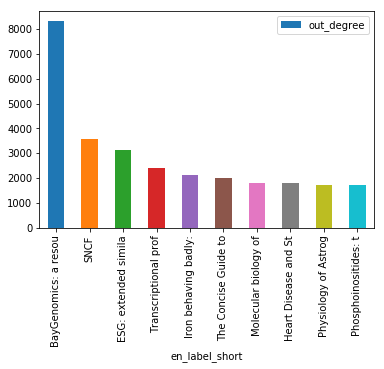

In [26]:
top_out_degree.plot.bar(x = 'en_label_short', y = 'out_degree');

We see a similar story for indegree: 75% of entities have 9 or fewer edges going in. The max indegree is almost 22 million! 

In [27]:
in_degree = triplets.groupby(['target_item_id'])[['target_item_id']].count()
in_degree = in_degree.rename(columns={"target_item_id": "in_degree"})
in_degree = in_degree.reset_index()
in_degree = in_degree.sort_values('in_degree', ascending = False)

The highest indegree entity is scholarly article!

In [28]:
top_in_degree = in_degree.iloc[:10]

In [29]:
top_in_degree = top_in_degree.merge(entities, left_on = ['target_item_id'], right_on = ['id'])

In [30]:
top_in_degree

,target_item_id,in_degree,id,en_label,en_description,enwiki_title
0,13442814,21910388,13442814,scholarly article,"article in an academic publication, usually pe...",NaN
1,5,5837659,5,human,"common name of Homo sapiens, unique extant spe...",Human
2,1860,4600258,1860,English,West Germanic language originating in England ...,English language
3,4167836,4465143,4167836,Wikimedia category,use with 'instance of' (P31) for Wikimedia cat...,Wikipedia:Categorization
4,6581097,3913958,6581097,male,human who is male (use with P21),NaN
5,16521,2596501,16521,taxon,"group of one or more organism(s), which a taxo...",Taxon
6,7432,2198219,7432,species,one of the basic units of biological classific...,Species
7,30,1968964,30,United States of America,federal republic in North America,United States
8,8054,1801629,8054,protein,biological molecule consisting of chains of am...,Protein
9,7187,1609904,7187,gene,basic physical and functional unit of heredity,Gene


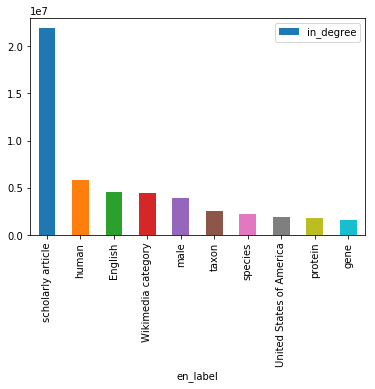

In [31]:
top_in_degree.plot.bar(x = 'en_label', y = 'in_degree');

In [32]:
in_degree['in_degree'].describe()

count    2.189076e+07
mean     1.750715e+01
std      5.276517e+03
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      2.191039e+07
Name: in_degree, dtype: float64

From exploration of the full graph we see that it would not be computationally feasible to use the full graph. As such we made a smaller graph consisting of only relations between wikipedia pages.

***

## NER Displacy

An example of NER with entities tagged.

In [33]:
import spacy
from spacy import displacy

ner = spacy.load('en_core_web_sm')
sample_text = "Apple Inc. is an American multinational technology company headquartered in Cupertino, California, that designs, develops, and sells consumer electronics, computer software, and online services. It is considered one of the Big Four tech companies along with Amazon, Google, and Facebook. The company's hardware products include the iPhone smartphone, the iPad tablet computer, the Mac personal computer, the iPod portable media player, the Apple Watch smartwatch, the Apple TV digital media player, the AirPods wireless earbuds and the HomePod smart speaker."
displacy.render(ner(sample_text), jupyter=True, style='ent')

***

## Node2vec Graph Embeddings

In deep learning approaches, it would be helpful to represent our knowledge graphs in a continuous vector space. After doing a review of graph embeddings approaches, node2vec seemed like a reasonable method. In short, node2vec uses a random walk to traverse the graph to learn the embeddings. Each node is then represented as a vector. In particular, this approach is useful as it allows us to balance the trade-off between capturing the local information in a graph and the global structure of the knowledge graph. 

In [34]:
from gensim.models import Word2Vec
model = Word2Vec.load('../data/graph_embedding_100000.model')

wikidata = pd.read_csv('../data/wikipages_cleaned.csv')
wikidata.dropna(inplace=True)

In [35]:
def id_title(data, idx):
    """Given a wikidata ID, extract the title"""
    return data[data['wikidata_numeric_id']==int(idx)]['target_page_title'].iloc[0]

Graph embedding of 100000 Wikidata entries projected onto 2 dimensions through PCA. This captures the structure and topology of the knowledge graph in 2D. If we plot the graph in plotly, we can see pockets of nodes which make sense. For example, countries are close to each other. 

/home/matteo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


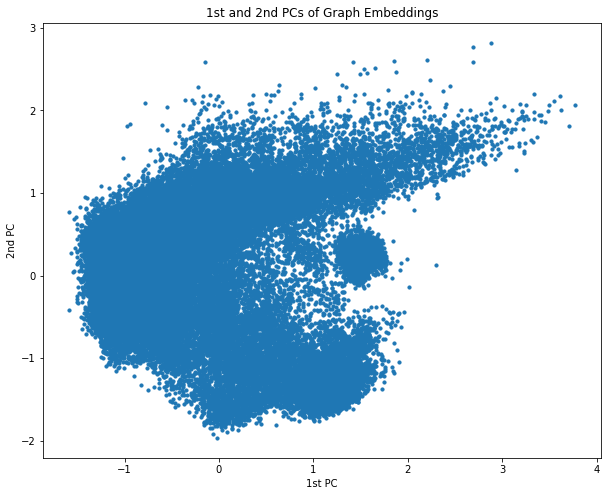

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# embedding for wikidata ID
X = model[model.wv.vocab]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plotly_X = pd.DataFrame(X_pca, columns=['1st PC', '2nd PC'])
plotly_X['titles'] = [id_title(wikidata, idx) for idx in list(model.wv.vocab)]

plt.figure(figsize=(10,8))
plt.scatter(plotly_X['1st PC'], plotly_X['2nd PC'], s=10)
plt.title('1st and 2nd PCs of Graph Embeddings')
plt.xlabel('1st PC')
plt.ylabel('2nd PC');

## Word2Vec Entity Text Embeddings

We also did a simple word2vec text embedding on the named entities from NER (5000 Wikipedia text articles). We similarly did a PCA and captured the 1st 2 PCs in a scatterplot. Due to the lower number of entities, the locations of the entities do not seem to be as useful as the graph embeddings.

In [41]:
entity_model = Word2Vec.load('../data/entity_embedding.model')

/home/matteo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


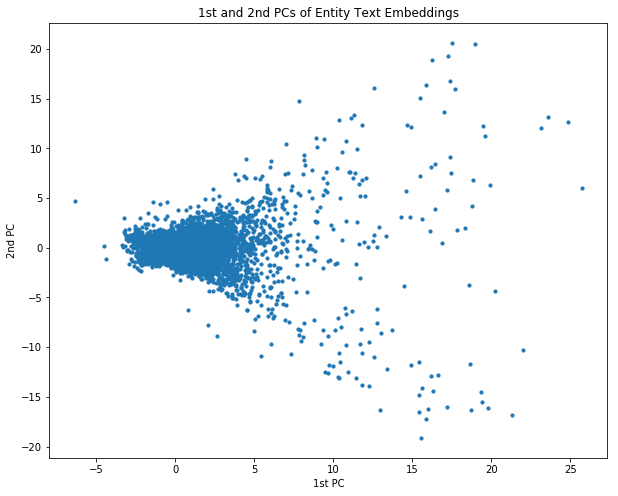

In [42]:
# embedding for wikidata ID
X_entity = entity_model[entity_model.wv.vocab]
pca_entity = PCA(n_components=2)
X_pca_entity = pca_entity.fit_transform(X_entity)
plotly_X_entity = pd.DataFrame(X_pca_entity, columns=['1st PC', '2nd PC'])
plotly_X_entity['entities'] = list(entity_model.wv.vocab)

plt.figure(figsize=(10,8))
plt.scatter(plotly_X_entity['1st PC'], plotly_X_entity['2nd PC'], s=10)
plt.title('1st and 2nd PCs of Entity Text Embeddings')
plt.xlabel('1st PC')
plt.ylabel('2nd PC');